<div align="center" style="color:black; font-size:16px;">
  <b>CVEN 5325: Fundamentals of Air Pollution</b>
</div>
<br>
<div align="center" style="color:darkblue; font-size:24px;">
  <b>Modeling Formaldehyde Concentration in Water</b><br>
  <span style="font-size:18px;">Temperature-Dependent Emission and Absorption in a Commercial Establishment</span>
</div>


<h3><center><font color = 'teal'> Aalok Sharma Kafle, MS, EIT </font></center></h3>

### Problem Statement
A carpeted area of $80 \, \text{m}^2$ in a commercial establishment emits formaldehyde ($ \text{HCHO} $) at a rate of $0.05 \, \text{mg/m}^2\cdot\text{h}$ at $22^\circ \text{C}$. The emission rate changes with temperature as follows:
- **Increase by 2%** per degree above $22^\circ \text{C}$.
- **Decrease by 1%** per degree below $22^\circ \text{C}$.

The establishment is $10 \, \text{m} \times 10 \, \text{m} \times 3 \, \text{m}$ in volume, with the following temperatures over 24 hours:
- **Morning (6 hours):** $10^\circ \text{C}$
- **Afternoon (6 hours):** $25^\circ \text{C}$
- **Evening (6 hours):** $22^\circ \text{C}$
- **Night (6 hours):** $15^\circ \text{C}$

Compute the concentration of formaldehyde ($ \text{HCHO} $) in a glass of water left in the room. The calculations consider the following:
- **Henry's Law Constant ($ H $):**
  - $ H = 5020 \, \text{M/atm} $ at $293 \, \text{K}$,
  - Temperature dependence given by:
    $$
    \ln H = \frac{6423 \pm 542}{T} - (13.4 \pm 2.0),
    $$
    where $ T $ is in Kelvin.


### Step 1: Constants and Parameters

We begin by defining the constants and parameters for the system, including the room dimensions, carpet area, base emission rate, and temperature-dependent factors for emission and Henry's constant.

In [2]:
import numpy as np

# Room dimensions and properties
room_area = 10 * 10  # m²
room_volume = 10 * 10 * 3  # m³
carpet_area = 80  # m²

# Emission rate and temperature adjustment factors
base_emission_rate = 0.05  # mg/m²·h at 22°C
temp_change_above = 0.02  # +2% per degree above 22°C
temp_change_below = -0.01  # -1% per degree below 22°C

# Henry's Law constant parameters
H_ref = 5020  # M/atm at 293 K
A = 6423  # Arrhenius numerator
B = -13.4  # Arrhenius offset
T_ref = 293  # Reference temperature (K)

# Time periods and temperatures (in hours and °C)
time_periods = [6, 6, 6, 6]  # hours for Morning, Afternoon, Evening, Night
temperatures = [10, 25, 22, 15]  # °C for Morning, Afternoon, Evening, Night

### Step 2: Time and Temperature Representation

The provided time periods and temperatures are converted into time-dependent arrays. Each temperature is converted to Kelvin for calculations involving Henry's constant:

- **Temperature conversion:** $T_{\text{Kelvin}} = T_{\text{Celsius}} + 273.15$
- Total simulation time: $24 \, \text{hours}$.


In [3]:
# Convert time and temperature information into time-dependent arrays
total_time_hours = sum(time_periods)
time_intervals = np.cumsum(time_periods)
temperatures_K = [temp + 273.15 for temp in temperatures]

### Step 3: Define Emission Rate and Henry's Constant Functions

1. **Emission Rate:**
   The emission rate is dynamically adjusted based on the temperature:
   \[
   E = \text{base rate} \times \left(1 + \Delta T \times \text{adjustment factor}\right)
   \]
   where:
   - $\Delta T = T - 22^\circ \text{C}$
   - Adjustment factor:
     - $+2\%$ for $T > 22^\circ \text{C}$
     - $-1\%$ for $T < 22^\circ \text{C}$.

2. **Henry's Constant:**
   Henry's constant is calculated using the Arrhenius equation:
   \[
   \ln H = \frac{A}{T} + B
   \]
   where $T$ is in Kelvin.

In [4]:
# Function to determine emission rate at a given time
def emission_rate(t):
    hour = (t / 3600) % total_time_hours  # Get current hour
    for i, interval in enumerate(time_intervals):
        if hour < interval:
            delta_T = temperatures[i] - 22
            if delta_T > 0:
                return base_emission_rate * (1 + delta_T * temp_change_above) * carpet_area / room_volume
            else:
                return base_emission_rate * (1 + delta_T * temp_change_below) * carpet_area / room_volume
    return 0

# Function to determine Henry's constant at a given time
def henrys_constant(t):
    hour = (t / 3600) % total_time_hours
    for i, interval in enumerate(time_intervals):
        if hour < interval:
            T = temperatures_K[i]
            ln_H = (A / T) + B
            return np.exp(ln_H)
    return np.exp((A / T_ref) + B)


### Step 4: Define the ODE System

The concentrations of formaldehyde in air ($C_{\text{air}}$) and water ($C_{\text{water}}$) are described by the following differential equations:

1. **Air Concentration:**
   $
   \frac{dC_{\text{air}}}{dt} = E - \frac{C_{\text{air}}}{H}
   $
   where:
   - $E$: Emission rate (mg/m³·s)
   - $H$: Henry's constant (M/atm)
  
  <br>

2. **Water Concentration:**
   $
   \frac{dC_{\text{water}}}{dt} = \frac{C_{\text{air}}}{H}
   $


In [5]:
# ODE system
def hcho_ode(t, y):
    C_air = y[0]  # Air concentration (mg/m³)
    C_water = y[1]  # Water concentration (mg/L)
    rate = emission_rate(t)
    H = henrys_constant(t)
    
    # Rate equations
    dC_air_dt = rate - (C_air / H)  # Emission into air and dissolution into water
    dC_water_dt = C_air / H  # Dissolution into water
    return [dC_air_dt, dC_water_dt]

### Step 5: Solve the ODE System

We solve the system of differential equations over a 24-hour period using the `solve_ivp` method, which dynamically adjusts the step size for accuracy.

In [7]:
from scipy.integrate import solve_ivp

# Initial conditions
initial_conditions = [0, 0]  # Start with zero concentrations in air and water

# Time span (24 hours in seconds)
t_span = (0, total_time_hours * 3600)
t_eval = np.linspace(0, total_time_hours * 3600, 1000)

# Solve the ODEs
solution = solve_ivp(hcho_ode, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Extract results
time_hours = solution.t / 3600  # Convert time to hours
C_air = solution.y[0]  # Air concentration (mg/m³)
C_water = solution.y[1]  # Water concentration (mg/L)

### Step 6: Visualize the Results

The plot shows the time-dependent evolution of formaldehyde concentrations in air and water.

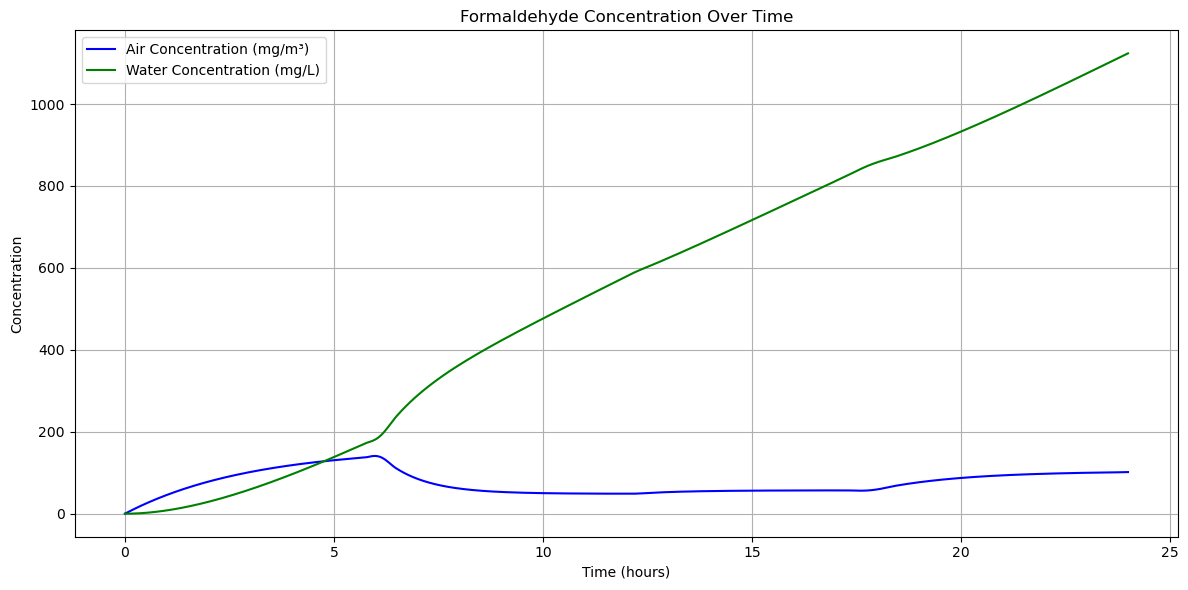

In [9]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(12, 6))

# Air Concentration
plt.plot(time_hours, C_air, label='Air Concentration (mg/m³)', color='blue')

# Water Concentration
plt.plot(time_hours, C_water, label='Water Concentration (mg/L)', color='green')

# Add labels and legends
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Formaldehyde Concentration Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Summary

The simulation results provide insights into the dynamics of formaldehyde emission and dissolution in a commercial space:

1. **Air Concentration ($C_{\text{air}}$):**
   - Airborne formaldehyde concentration rises initially due to emissions from the carpeted area.
   - It stabilizes or decreases over time as formaldehyde dissolves into water, particularly during periods of higher solubility (cooler temperatures).
   
<br>

2. **Water Concentration ($C_{\text{water}}$):**
   - Formaldehyde concentration in water increases steadily as it absorbs formaldehyde from the air.
   - The rate of increase is higher during periods with elevated air concentrations or when Henry’s constant is favorable (lower temperatures).
   
<br>

3. **Impact of Temperature:**
   - High temperatures (e.g., $25^\circ \text{C}$ in the afternoon) increase emissions but reduce dissolution efficiency (lower Henry's constant).
   - Low temperatures (e.g., $10^\circ \text{C}$ in the morning) result in lower emissions but higher solubility, driving more formaldehyde into the water.
   
<br>

4. **Model Assumptions:**
   - The system assumes no backward flux of formaldehyde from water to air, potentially overestimating water concentrations.
   - Ventilation effects on removing formaldehyde are not considered, which may result in overestimation of air concentrations.
   
<br>

5. **Conclusion:**
   - The results align with the physical understanding of temperature-dependent emission and solubility.
   - For more realistic outcomes, the model could incorporate reverse flux (air-water equilibrium) and ventilation effects.
   
<br>

This simulation highlights the critical role of temperature in regulating formaldehyde dynamics in enclosed environments and its eventual partitioning into water.
